In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sbaghbidi_human_faces_object_detection_path = kagglehub.dataset_download('sbaghbidi/human-faces-object-detection')

print('Data source import complete.')


100%|██████████| 498M/498M [00:23<00:00, 22.2MB/s]

Extracting files...


Data source import complete.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import kagglehub
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torchvision import transforms

# Download latest version
path = kagglehub.dataset_download("sbaghbidi/human-faces-object-detection")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/sbaghbidi/human-faces-object-detection/versions/1


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [5]:
class Dataset25(Dataset):

  def __init__(self, path, grid_size = 13, YOLO_shape = (1000, 1000), transform = None):

    self.__path = path
    self.__transform = transform
    self.__YOLO_shape = YOLO_shape
    self.__length = 0
    self.__targets = []
    self.__images = []
    self.__grid_size = grid_size
    csv_path = path + '/faces.csv'
    df = pd.read_csv(csv_path)
    df['box_width'] = df['x1'] - df['x0']
    df['box_height'] = df['y1'] - df['y0']

    for actual_path in self.__get_image_os(path + '/images'):


      try:

          row = df[df['image_name'] == actual_path.split('/')[-1]]
          if row.empty:
              print(f"Warning: Image {actual_path} not found in DataFrame.")
              continue

          ratio = row['box_width'].iloc[0] * row['box_height'].iloc[0] / (row['width'].iloc[0] * row['height'].iloc[0])

          if ratio >= 0.0 and ratio < 0.25:

              target = np.zeros((self.__grid_size, self.__grid_size, 5), dtype=np.float32)
              img = Image.open(actual_path)

              x_center = row['x0'].iloc[0] / img.width *  YOLO_shape[0]
              y_center = row['y0'].iloc[0] / img.height * YOLO_shape[1]


              width = row['box_width'].iloc[0] * YOLO_shape[0] / img.width
              height = row['box_height'].iloc[0] * YOLO_shape[1] / img.height

              grid_x = (self.__grid_size / YOLO_shape[0] * x_center)
              grid_y = (self.__grid_size / YOLO_shape[1] * y_center)

              target[int(grid_y)][int(grid_x)] = [1.0, (grid_x - int(grid_x)) * YOLO_shape[0] / self.__grid_size, (grid_y - int(grid_y)) * YOLO_shape[0] / self.__grid_size, width, height]
              target = target.reshape(self.__grid_size ** 2, 5)
              self.__targets.append(target)
              self.__images.append(actual_path)
              self.__length += 1

      except FileNotFoundError:
          print(f"Error: Image file not found: {actual_path}")
      except Exception as e:
          print(f"An error occurred: {e}")

    print("Images and targets created successfully.")

  def get_target(self, index):

      return self.__targets[index]

  def get_image_path(self, index):

    return self.__images[index]

  def __get_image_os(self, folder_path):

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            yield os.path.join(folder_path, filename)
    return None

  def __len__(self):

    return self.__length

  def __getitem__(self, index):

      img = Image.open(self.__images[index])
      img = img.resize(self.__YOLO_shape)
      img = img.convert('L')

      target = torch.from_numpy(self.__targets[index]).float()

      if self.__transform:

        img = self.__transform(img)

      return img, target


In [6]:
dt = Dataset25(path, transform= transform)

Images and targets created successfully.


In [7]:
train_data, validation_data = random_split(dt, [0.8, 0.2])

In [8]:
train_loader = DataLoader(train_data, batch_size = 4, shuffle = True)
validation_loader = DataLoader(validation_data, batch_size = 4, shuffle = True)

In [9]:
class EarlyStopping:

    def __init__(self, patience=10, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered.")

In [10]:
class YoloLoss(nn.Module):
    def __init__(self, lambda_l2=0.001, lambda_conf=1.0, lambda_box = 0.0001):

        super(YoloLoss, self).__init__()
        self.lambda_l2 = lambda_l2
        self.lambda_conf = lambda_conf
        self.lambda_box = lambda_box
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')


    def forward(self, predictions, targets):

        object_mask = targets[..., 0] == 1
        no_object_mask = targets[..., 0] == 0

        pred_conf = torch.sigmoid(predictions[..., 0])
        target_conf = targets[..., 0]

        new_target_conf = targets[..., 0].clone()

        if not isinstance(new_target_conf, torch.Tensor):
          raise ValueError("new_target_conf is not a tensor!")

        new_target_conf[no_object_mask] = 0.5

        conf_loss_obj = self.bce_loss(pred_conf[object_mask], target_conf[object_mask])
        conf_loss_no_obj = self.bce_loss(pred_conf[no_object_mask], target_conf[no_object_mask])

        conf_loss_obj = conf_loss_obj.mean()
        conf_loss_no_obj = conf_loss_no_obj.mean()

        pred_boxes = predictions[object_mask]
        target_boxes = targets[object_mask]

        if pred_boxes.numel() > 0:
            loss_position = torch.mean((pred_boxes[:, 1:3] - target_boxes[:, 1:3]) ** 2)
            loss_size = torch.mean((pred_boxes[:, 3:5] - target_boxes[:, 3:5]) ** 2)
            box_loss = loss_position + loss_size
        else:
            box_loss = torch.tensor(0.0, device=predictions.device)

        l2_reg = 0
        for name, param in model.named_parameters():
            if 'bias' not in name:
                l2_reg += torch.norm(param) ** 2

        l2_loss = self.lambda_l2 * l2_reg

        total_loss = self.lambda_box * box_loss + self.lambda_conf * (conf_loss_obj + conf_loss_no_obj) + l2_loss

        return total_loss, self.lambda_conf * (conf_loss_obj + conf_loss_no_obj), self.lambda_box * box_loss, l2_loss

In [11]:
class YoloModel(nn.Module):
    def __init__(self):
        super(YoloModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(4)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=4)

        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=7, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        '''
        self.conv6 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=7, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(32)
        self.pool6 = nn.MaxPool2d(kernel_size=2, stride=2)
        '''
        self.conv7 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=2, dilation=2)
        self.bn7 = nn.BatchNorm2d(64)

        self.final_conv = nn.Conv2d(in_channels=64, out_channels=5, kernel_size=1)


    def forward(self, x):
        x = self.pool1(nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.pool2(nn.ReLU()(self.bn2(self.conv2(x))))
        x = self.pool3(nn.ReLU()(self.bn3(self.conv3(x))))
        x = self.pool4(nn.ReLU()(self.bn4(self.conv4(x))))
        x = self.pool5(nn.ReLU()(self.bn5(self.conv5(x))))
        #x = self.pool6(nn.ReLU()(self.bn6(self.conv6(x))))
        x = nn.ReLU()(self.bn7(self.conv7(x)))
        x = self.final_conv(x)

        batch_size = x.size(0)
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(batch_size, -1, 5)

        return x

In [12]:

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_conf_loss = 0
    total_box_loss = 0
    total_l2_loss = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):

        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss, conf_loss, box_loss, l2_loss = criterion(outputs, targets)

        loss.backward()

        for name, param in model.named_parameters():

            if 'bias' in name:

                param.grad = -param.grad

        optimizer.step()

        total_loss += loss.item()
        total_conf_loss += conf_loss.item()
        total_box_loss += box_loss.item()
        total_l2_loss += l2_loss.item()

        if batch_idx % 12 == 0:
            print(f'Batch {batch_idx}, Total Loss: {loss.item():.4f}, '
                  f'Confidence Loss: {conf_loss.item():.4f}, '
                  f'Box Loss: {box_loss.item():.4f}, '
                  f'L2 Loss: {l2_loss.item():.4f}')


        if device == 'cuda':
            torch.cuda.empty_cache()

    return total_loss / len(dataloader)



In [13]:
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_probability_diff = []
    total_probability_diff1 = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss, conf_loss, box_loss, l2_loss = criterion(outputs, targets)
            total_loss += loss.item()

            object_mask = targets[..., 0] > 0
            object_mask1 = targets[..., 0] == 0

            pred_probabilities = torch.sigmoid(outputs[..., 0])


            if object_mask.any():

                predicted_probs_for_objects = pred_probabilities[object_mask]
                predicted_probs_for_objects1 = pred_probabilities[object_mask1]

                target_probs_for_objects = targets[..., 0][object_mask]
                target_probs_for_objects1 = targets[..., 0][object_mask1]

                probability_diff = predicted_probs_for_objects - target_probs_for_objects
                probability_diff1 = predicted_probs_for_objects1 - target_probs_for_objects1
                total_probability_diff.extend(probability_diff.cpu().numpy())
                total_probability_diff1.extend(probability_diff1.cpu().numpy())


    avg_loss = total_loss / len(dataloader)
    avg_probability_diff = np.mean(np.abs(total_probability_diff)) if total_probability_diff else 0
    avg_probability_diff1 = np.mean(np.abs(total_probability_diff1)) if total_probability_diff1 else 0

    return avg_loss, avg_probability_diff, avg_probability_diff1


In [15]:
model = YoloModel()
criterion = YoloLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1,min_lr=10**(-12))


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# Основной цикл обучения
early_stopping = EarlyStopping(patience=5, verbose=True)
num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    scheduler.step(train_loss)

    val_loss, avg_prob, avg_prob_neg = validate_epoch(model, validation_loader, criterion, device)

    current_lr = scheduler.get_last_lr()[0]
    print(f'Epoch {epoch+1}/{num_epochs}, Average Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Probability: {avg_prob:.4f}, Negative Probability: {avg_prob_neg:.4f}, Learning Rate: {current_lr}')


    early_stopping(val_loss)
    if early_stopping.early_stop and current_lr <= 10**(-10):
        print("Training stopped.")
        break


Batch 0, Total Loss: 12.1946, Confidence Loss: 1.4648, Box Loss: 10.5200, L2 Loss: 0.2099
Batch 12, Total Loss: 9.2178, Confidence Loss: 1.3455, Box Loss: 7.6633, L2 Loss: 0.2091
Batch 24, Total Loss: 12.7228, Confidence Loss: 1.3070, Box Loss: 11.2073, L2 Loss: 0.2085
Batch 36, Total Loss: 7.6346, Confidence Loss: 1.2527, Box Loss: 6.1736, L2 Loss: 0.2084
Batch 48, Total Loss: 13.6122, Confidence Loss: 1.3141, Box Loss: 12.0894, L2 Loss: 0.2087
Batch 60, Total Loss: 5.7244, Confidence Loss: 1.2776, Box Loss: 4.2370, L2 Loss: 0.2098
Batch 72, Total Loss: 8.7756, Confidence Loss: 1.2583, Box Loss: 7.3062, L2 Loss: 0.2111
Batch 84, Total Loss: 11.1747, Confidence Loss: 1.2383, Box Loss: 9.7235, L2 Loss: 0.2129
Batch 96, Total Loss: 8.2927, Confidence Loss: 1.2014, Box Loss: 6.8762, L2 Loss: 0.2151
Batch 108, Total Loss: 4.8915, Confidence Loss: 1.2988, Box Loss: 3.3751, L2 Loss: 0.2176
Batch 120, Total Loss: 6.4727, Confidence Loss: 1.2081, Box Loss: 5.0443, L2 Loss: 0.2203
Batch 132, To

In [16]:

def save_checkpoint(model, optimizer, scheduler, epoch, loss, filename):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
    }, filename)


save_checkpoint(model, optimizer, scheduler, epoch, train_loss, '/content/drive/MyDrive/checkpoint.pth')


<ipython-input-36-7f9e0e95711d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Execution time: 0.027236 seconds


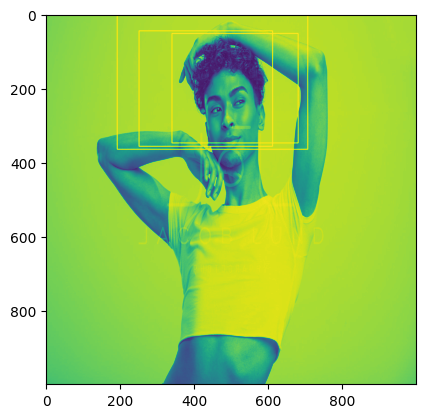

In [36]:
def load_model(checkpoint_path, model_class, optimizer_class=None, device=None):
    checkpoint = torch.load(checkpoint_path)

    model = YoloModel()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    if optimizer_class:
        optimizer = optimizer_class()
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return model, optimizer, checkpoint['epoch'], checkpoint['loss']

    return model, checkpoint['epoch'], checkpoint['loss']


def preprocess_image(img, device):
    img = img.unsqueeze(0)
    img = img.to(device)
    return img

def get_model_predictions(model, img):
    with torch.no_grad():
        outputs = model(img)
    return outputs

def process_outputs(outputs, size=13):

    confidence = torch.sigmoid(outputs[0, ..., 0]).reshape(size, size)
    positions = outputs[0, ..., 1:3].reshape(size, size, 2)
    sizes = outputs[0, ..., 3:5].reshape(size, size, 2)

    return confidence, positions, sizes

def draw_bounding_box(img, positions, sizes, confidence, device, size=13):

    img = img.cpu()
    img_np = img.numpy()

    img_np = np.transpose(img_np[0], (1, 2, 0)) * 255.0


    for x in range(size):
        for y in range(size):
            if confidence[x, y] > 0.999999:
                pos_x, pos_y = positions[x, y]

                pos_x = pos_x.item()
                pos_y = pos_y.item()

                width, height = sizes[x, y]

                top_left = (int((x+1) * 1000 / size - width / 2 + pos_x), int((y+1) * 1000 / size - height / 2 + pos_y))
                bottom_right = (int((x+1) * 1000 / size + width / 2 + pos_x), int((y+1) * 1000 / size + height / 2 + pos_y))

                #print(pos_x, pos_y, top_left, bottom_right)

                img_np = cv2.rectangle(img_np, top_left[::-1], bottom_right[::-1], (255, 0, 0), 2)

    return img_np

def check_single_image(checkpoint_path, dataset, index, device, size=13):
    model, _, _ = load_model(checkpoint_path, YoloModel, device = device)
    start_time = time.perf_counter()
    img, target = dataset[index]
    #print(dataset.get_target(index))
    img = preprocess_image(img, device)
    outputs = get_model_predictions(model, img)
    confidence, positions, sizes = process_outputs(outputs, size)
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f"Execution time: {elapsed_time:.6f} seconds")

    img_with_boxes = draw_bounding_box(img, positions, sizes, confidence, device, size=13)

    plt.imshow(img_with_boxes)
    plt.axis('on')
    plt.show()

import time
import cv2
check_single_image("/content/drive/MyDrive/checkpoint.pth", dt, 13, torch.device('cuda' if torch.cuda.is_available() else 'cpu'))